<a href="https://colab.research.google.com/github/GopalKrishna-India/Geospatial/blob/Child_Branch/Tensorflow_Decision_Forests_%2B_Earth_Engine_issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-decision-forests==0.2.4 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import pandas as pd

## Model setup
We will prepare a toy example of a decision forests model that predicts ndvi from sentinel 2 data  

In [ ]:
# create the random forest
rf=tfdf.keras.RandomForestModel(
    verbose=1,
    hyperparameter_template='better_default',
    task=tfdf.keras.Task.REGRESSION,
    num_trees=10,
    compute_oob_variable_importances=True,
    name=f"random_forest_layer"
    )
  
rf.compile(metrics=[tf.keras.metrics.RootMeanSquaredError()])


Resolve hyper-parameter template "better_default" to "better_default@v1" -> {'winner_take_all': True}.
Use /tmp/tmpgszw3otv as temporary training directory


In [ ]:
# train on some made up data
mock_data = pd.DataFrame(
    {"ndvi": [0.045926817, 0.36869645, 0.32059526, -0.049917717, 0.161236],
     "B8": [6946, 3793, 3594, 1299, 3448],
     "B4": [6336, 1749.5, 1849, 1435.5, 2490.5]
     }
)

mock_data = tfdf.keras.pd_dataframe_to_tf_dataset(mock_data, label="ndvi", task=tfdf.keras.Task.REGRESSION)
rf.fit(mock_data)

Starting reading the dataset


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.087753
Training model
Model trained in 0:00:00.011161
Compiling model
1/1 [==============================] - 0s 108ms/step


In [ ]:
# Guess at the sort of data sent over to AI platform by EE
best_guess_ee_input = {
    'B8': tf.constant([[1,2,3,4],
                       [1.1,2.1,3.1,4.1],
                       [1.2,2.3,2.4,2.5],
                       [3.1,3.15,3.2,3.4]]),
    'B4': tf.constant([[10,20,30,40],
                       [11,21,31,41],
                       [21,31,41,51],
                       [31,32,33,34]])                     
}



best_guess_ee_input = {k: tf.reshape(v, [4,4,1]) for (k,v) in best_guess_ee_input.items()}
# @Nick: first thing I'm assuming is that the serialized TensorProtos will be 
# sent over in the format [x,y,bands], so in the case above it would be a 4x4 
# pixel patch, with a 3rd dimension of rank 1 as the values are keyed by band


#Decision forest models cannot natively consume data in this format - they 
# expect a dataframe-like array, where rows are instances and columns are 
# features. uncomment the below line to see the error

# rf.predict(best_guess_ee_input)


In [ ]:
# in order to feed the data to the random forest, we need to do some reshaping to a new 
# shape of (None, 1) like so, then we get the expected 16 predictions: 
best_guess_ee_input_reshaped = {k: tf.reshape(v, [-1,1]) for (k,v) in best_guess_ee_input.items()}
rf.predict(best_guess_ee_input_reshaped)


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

## Extending the model to the assumed inputs from EE

We therefore need to extend the new model to make it incorporate the reshaping steps as part of the model. It assumes that Earth Engine wants the responses back in the same shape that were sent over. 

In [ ]:
# create a custom keras layer to do the reshaping of the input data
class ReshapeInputEE(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, tensor_dict):
    return_dict = {}
    for (k,v) in tensor_dict.items():
      return_dict[k] = tf.reshape(v, [-1,1])
    return return_dict
  
  def get_config(self):
    config = super().get_config()
    return config


# this layer reshapes the model predictions to what I assume EE requires 
# (same shape as data sent over)
class ReshapeOutputEE(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs):
    input_dict, model_predictions = inputs[0], inputs[1]
    # as well as the predictions, this layer needs to know the shape of the original input data
    shape = tf.shape(input_dict['B8'])
    return tf.reshape(model_predictions, shape)
  
  def get_config(self):
    config = super().get_config()
    return config


input_reshaper = ReshapeInputEE(name="input_reshaper")

output_reshaper = ReshapeOutputEE(name="output_reshaper")

# create the new inputs
inputs = {
    'B8': tf.keras.Input(shape=(None, 1), name="B8_input"),
    'B4': tf.keras.Input(shape=(None, 1), name="B4_input")
}

# create the model

new_model = input_reshaper(inputs)
new_model = rf(new_model)
new_model = output_reshaper([inputs, new_model])

new_model = tf.keras.Model(inputs, new_model, name="random_forest_with_reshaping")

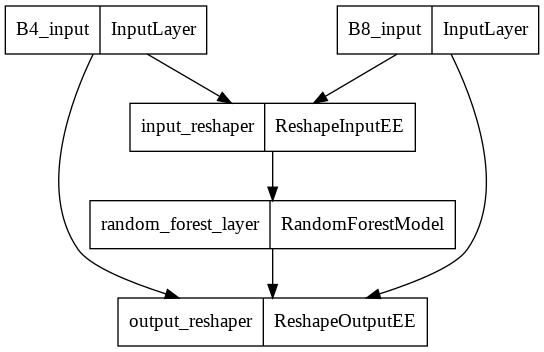

In [ ]:
# plot the model to show the new architecture
tf.keras.utils.plot_model(new_model)

In [ ]:
# now it will work with input data in the format [None, None, 1] i.e. [x,y,bands]
new_model.predict(best_guess_ee_input)

array([[[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]]], dtype=float32)

## Implementation of 'EEification' (`earthengine model prepare` command)

The `earthengine model prepare` does not work with Tensorflow decision forests (TFDF), due to some assumed incompatibility between the TFDF library and TF1 (TFDF is only compatible with TF2, whereas the python `earthengine` package uses TF1). I've attempted to reimplement it using TF2 layers.

In [ ]:
class DeserlializeInputEE(tf.keras.layers.Layer):
  # It appears that the decoding from base64 is done by the Tensorflow serving 
  # container, so just need to deseralize the tensorprotos
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, tensor_dict):
    return_dict = {}
    for (k,v) in tensor_dict.items():
      return_dict[k] = tf.reshape(tf.io.decode_raw(v, tf.float32), [-1,1])
    return return_dict
  
  def get_config(self):
    config = super().get_config()
    return config

class ReserlializeInputEE(tf.keras.layers.Layer):
  #...however the container does not base64 encode the responses so we need to 
  # do it here
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, tensor_input):
    return tf.reshape(tf.io.encode_base64(tf.io.serialize_tensor(tensor_input)), [1])
  
  def get_config(self):
    config = super().get_config()
    return config

input_deserializer = DeserlializeInputEE()

output_deserilaizer = ReserlializeInputEE()

# the new inputs will be of type string as they are serialized
serlialized_inputs = {
    'B8': tf.keras.Input(shape=(None,), dtype='string', name="B8"),
    'B4': tf.keras.Input(shape=(None,), dtype='string', name="B4")
}


updated_model_input = input_deserializer(serlialized_inputs)
updated_model = new_model(updated_model_input)
updated_model = output_deserilaizer(updated_model)

updated_model= tf.keras.Model(serlialized_inputs, updated_model)



In [ ]:
# uncomment to download the model
# updated_model.save("updated_model")
# !zip -r /content/updated_model.zip /content/updated_model
# from google.colab import files
# files.download("/content/updated_model.zip")

INFO:tensorflow:Assets written to: updated_model/assets


INFO:tensorflow:Assets written to: updated_model/assets


updating: content/updated_model/ (stored 0%)
updating: content/updated_model/assets/ (stored 0%)
updating: content/updated_model/assets/header.pb (deflated 28%)
updating: content/updated_model/assets/data_spec.pb (deflated 18%)
updating: content/updated_model/assets/random_forest_header.pb (deflated 34%)
updating: content/updated_model/assets/nodes-00000-of-00001 (deflated 59%)
updating: content/updated_model/assets/done (stored 0%)
updating: content/updated_model/saved_model.pb (deflated 91%)
updating: content/updated_model/variables/ (stored 0%)
updating: content/updated_model/variables/variables.data-00000-of-00001 (deflated 75%)
updating: content/updated_model/variables/variables.index (deflated 25%)
updating: content/updated_model/keras_metadata.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

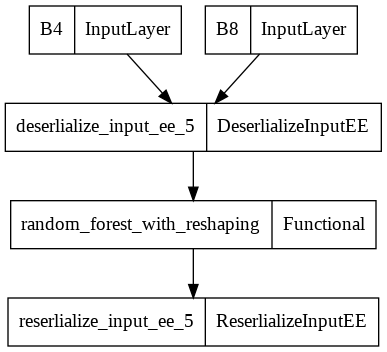

In [ ]:
# plot the new model with the additional deserliazation and reserialization steps
tf.keras.utils.plot_model(updated_model)

##Notes for the EE team: 

- I have deployed this model on AI platform, with a custom Tensorflow serving Docker container (I can share if helpful). When sending over predictions the error is: `Tile error: Returned tensor could not be symmetrically cropped to expected size: [1, 1], got: [53792, 1]` . See here for how the data is prepared: https://code.earthengine.google.com/a8bd982c0c1376e861ea403837c0b8cd. It won't work for anybody else, but at least potential issues can be identified. So basically it appears to correctly make predictions but I think the issue is with the shape of the tensor sent back.
